In [289]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, BatchNormalization
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import  train_test_split
from keras import backend as K
from keras import optimizers
import keras as k
import time
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [290]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("data.csv")
data.head()
print(data.shape)

(149503, 7)


In [291]:
data.describe()

,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
count,149503.000000,1.495030e+05,149503.000000,149503.000000,149503.000000,149503.000000,149503.000000
mean,142.099270,3.220595e+02,47.706389,86.529215,26.890545,17.069971,1.354455
std,36.681588,1.541262e+02,2.715745,1.328715,13.581330,5.262956,1.256869
min,106.314072,1.400000e-08,31.174412,66.683716,0.000000,4.674084,-0.015000
25%,116.823456,2.233254e+02,46.508974,85.869404,19.915110,12.605148,0.625000
50%,126.246201,2.922540e+02,47.805603,86.558945,23.248041,18.143646,1.223000
75%,162.959183,4.117750e+02,49.147144,87.241043,31.738495,21.310923,1.802000
max,265.274353,9.227142e+02,57.733215,94.996307,91.331413,23.219999,50.917000


In [292]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]

In [293]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

In [294]:
data_la.shape

(146503, 7)

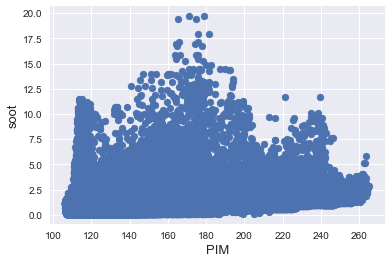

In [295]:
#观察各变量与target之间的关系
fig, ax = plt.subplots()
ax.scatter(x = data_la['PIM'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('PIM', fontsize=13)
plt.show()

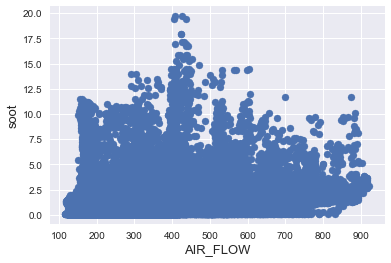

In [296]:
fig, ax = plt.subplots()
ax.scatter(x = data_la['AIR_FLOW'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('AIR_FLOW', fontsize=13)
plt.show()

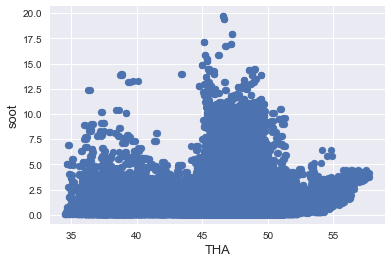

In [297]:
fig, ax = plt.subplots()
ax.scatter(x = data_la['THA'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('THA', fontsize=13)
plt.show()

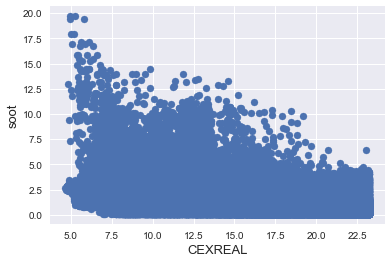

In [298]:
fig, ax = plt.subplots()
ax.scatter(x = data_la['CEXREAL'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('CEXREAL', fontsize=13)
plt.show()

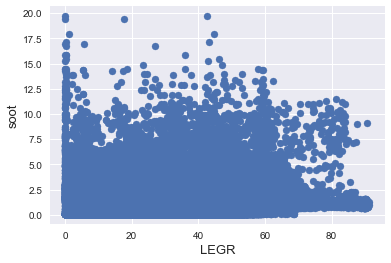

In [299]:
fig, ax = plt.subplots()
ax.scatter(x = data_la['LEGR'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('LEGR', fontsize=13)
plt.show()

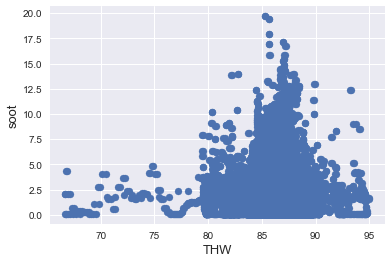

In [300]:
fig, ax = plt.subplots()
ax.scatter(x = data_la['THW'], y = data_la['soot'])
plt.ylabel('soot', fontsize=13)
plt.xlabel('THW', fontsize=13)
plt.show()


 mu = 1.37 and sigma = 1.20



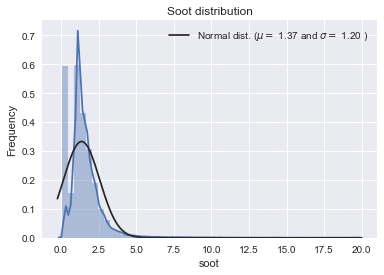

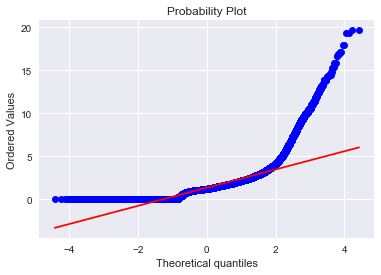

In [301]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(data_la['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_la['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_la['soot'], plot=plt)
plt.show()


 mu = 1.32 and sigma = 1.24



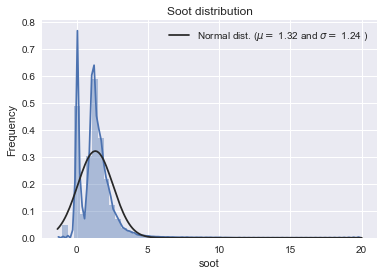

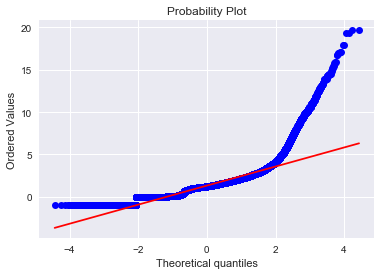

In [302]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.show()

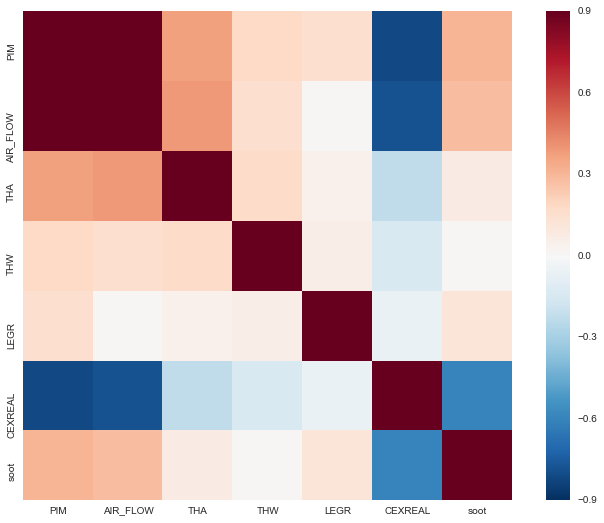

In [304]:
#Correlation map to see how features are correlated with SalePrice
corrmat = data_la.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [273]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [274]:
#Validation function
n_folds = 5
features =  data_la.columns.values[0:5]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
train = data[features]

test = pd.read_csv('test.csv')
mean = train.mean(axis=0)
train -= mean
std = train.std(axis=0)
train /= std
test -= mean
test /= std


y_train = data['soot'].values

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [275]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
#model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             #learning_rate=0.05, max_depth=3, 
                             #min_child_weight=1.7817, n_estimators=2200,
                             #reg_alpha=0.4640, reg_lambda=0.8571,
                             #subsample=0.5213, silent=1,nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [276]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4184 (0.0034)



In [277]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4184 (0.0034)



In [215]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

MemoryError: 

In [216]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [288]:
#LGBM模型.施加random状态
evals_result = {}  #记录训练结果所用
features =  data_la.columns.values[0:5]
X_train = train.values
X_test = test[features].values
y_train = data_la['soot'].values
target =  data_la['soot']
predictions = np.zeros(len(test))
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_lgb = np.zeros(len(data_la))
#predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 20000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],evals_result=evals_result,verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.0873918	valid_1's l2: 0.0920667
[400]	training's l2: 0.0729466	valid_1's l2: 0.0782731
[600]	training's l2: 0.0665107	valid_1's l2: 0.0723924
[800]	training's l2: 0.062443	valid_1's l2: 0.068834
[1000]	training's l2: 0.0593764	valid_1's l2: 0.0662876
[1200]	training's l2: 0.0567323	valid_1's l2: 0.0641436
[1400]	training's l2: 0.0544423	valid_1's l2: 0.0623465
[1600]	training's l2: 0.0524819	valid_1's l2: 0.0608272
[1800]	training's l2: 0.0507985	valid_1's l2: 0.0595468
[2000]	training's l2: 0.0493139	valid_1's l2: 0.058452
[2200]	training's l2: 0.0479591	valid_1's l2: 0.0574642
[2400]	training's l2: 0.0467158	valid_1's l2: 0.0565671
[2600]	training's l2: 0.04559	valid_1's l2: 0.0557748
[2800]	training's l2: 0.0445048	valid_1's l2: 0.0550246
[3000]	training's l2: 0.0434695	valid_1's l2: 0.0543131
[3200]	training's l2: 0.0425772	valid_1's l2: 0.0537052
[3400]	training's l2: 0.041718	valid_1's 

[8600]	training's l2: 0.0293478	valid_1's l2: 0.0441895
[8800]	training's l2: 0.0290241	valid_1's l2: 0.0440473
[9000]	training's l2: 0.0287277	valid_1's l2: 0.0439275
[9200]	training's l2: 0.0284329	valid_1's l2: 0.0437985
[9400]	training's l2: 0.0281509	valid_1's l2: 0.0436914
[9600]	training's l2: 0.0278703	valid_1's l2: 0.0435878
[9800]	training's l2: 0.027595	valid_1's l2: 0.0434711
[10000]	training's l2: 0.027331	valid_1's l2: 0.0433746
[10200]	training's l2: 0.0270666	valid_1's l2: 0.0432653
[10400]	training's l2: 0.0268015	valid_1's l2: 0.0431673
[10600]	training's l2: 0.0265374	valid_1's l2: 0.0430787
[10800]	training's l2: 0.0262895	valid_1's l2: 0.0429853
[11000]	training's l2: 0.0260492	valid_1's l2: 0.0428937
[11200]	training's l2: 0.0258102	valid_1's l2: 0.042809
[11400]	training's l2: 0.0255753	valid_1's l2: 0.0427176
[11600]	training's l2: 0.0253394	valid_1's l2: 0.0426368
[11800]	training's l2: 0.0251074	valid_1's l2: 0.042552
[12000]	training's l2: 0.024891	valid_1's 

[17200]	training's l2: 0.0202039	valid_1's l2: 0.0412421
[17400]	training's l2: 0.0200566	valid_1's l2: 0.0412012
[17600]	training's l2: 0.0199083	valid_1's l2: 0.0411615
[17800]	training's l2: 0.0197679	valid_1's l2: 0.0411252
[18000]	training's l2: 0.0196281	valid_1's l2: 0.041091
[18200]	training's l2: 0.0194913	valid_1's l2: 0.0410544
[18400]	training's l2: 0.0193517	valid_1's l2: 0.0410204
[18600]	training's l2: 0.0192187	valid_1's l2: 0.0409901
[18800]	training's l2: 0.0190811	valid_1's l2: 0.0409559
[19000]	training's l2: 0.0189497	valid_1's l2: 0.040923
[19200]	training's l2: 0.0188142	valid_1's l2: 0.0408882
[19400]	training's l2: 0.0186879	valid_1's l2: 0.0408546
[19600]	training's l2: 0.0185622	valid_1's l2: 0.040826
[19800]	training's l2: 0.018435	valid_1's l2: 0.0407939
[20000]	training's l2: 0.0183058	valid_1's l2: 0.0407634
Did not meet early stopping. Best iteration is:
[20000]	training's l2: 0.0183058	valid_1's l2: 0.0407634
fold n°4
Training until validation scores do

[5200]	training's l2: 0.0361671	valid_1's l2: 0.048258
[5400]	training's l2: 0.035646	valid_1's l2: 0.0479804
[5600]	training's l2: 0.0350992	valid_1's l2: 0.0476681
[5800]	training's l2: 0.0346293	valid_1's l2: 0.0474197
[6000]	training's l2: 0.0341675	valid_1's l2: 0.047194
[6200]	training's l2: 0.0337063	valid_1's l2: 0.0469683
[6400]	training's l2: 0.0332559	valid_1's l2: 0.0467341
[6600]	training's l2: 0.0328303	valid_1's l2: 0.0465237
[6800]	training's l2: 0.0324314	valid_1's l2: 0.0463224
[7000]	training's l2: 0.0320327	valid_1's l2: 0.0461351
[7200]	training's l2: 0.0316522	valid_1's l2: 0.0459587
[7400]	training's l2: 0.0312902	valid_1's l2: 0.0457952
[7600]	training's l2: 0.0309265	valid_1's l2: 0.0456144
[7800]	training's l2: 0.0305818	valid_1's l2: 0.0454498
[8000]	training's l2: 0.0302372	valid_1's l2: 0.0452949
[8200]	training's l2: 0.0299157	valid_1's l2: 0.0451443
[8400]	training's l2: 0.0295959	valid_1's l2: 0.0449938
[8600]	training's l2: 0.0292771	valid_1's l2: 0.044

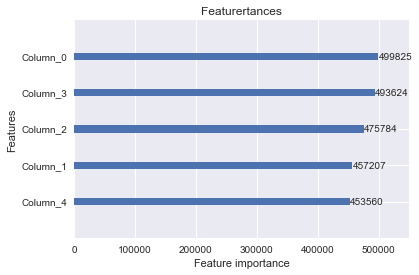

In [286]:
plt.figure(figsize=(12,6))
lgb.plot_importance(clf, max_num_features=6)
plt.title("Featurertances")
plt.show()

画出训练结果...


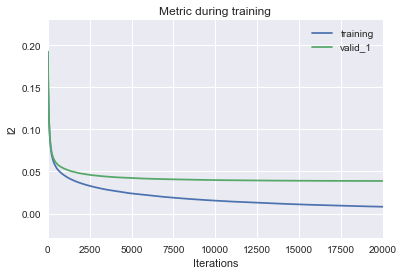

In [287]:
print('画出训练结果...')
ax = lgb.plot_metric(evals_result)#metric的值与之前的params里面的值对应
plt.show()

In [279]:
lgb_pred = np.expm1(predictions)

In [281]:
sub = pd.DataFrame()
sub['soot'] = lgb_pred
sub.to_csv('submission.csv',index=False)

In [21]:
#LGBM模型，不添加random状态
features =  data_la.columns.values[0:5]
X_train = data_la[features].values
y_train = data_la['soot'].values
target =  data_la['soot']
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_lgb = np.zeros(len(data_la))
#predictions_lgb = np.zeros(len(test))

evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 20000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], evals_result=evals_result,verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    #predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.670554	valid_1's l2: 0.738979
[400]	training's l2: 0.540739	valid_1's l2: 0.634709
[600]	training's l2: 0.480232	valid_1's l2: 0.591891
[800]	training's l2: 0.44192	valid_1's l2: 0.568238
[1000]	training's l2: 0.414002	valid_1's l2: 0.551682
[1200]	training's l2: 0.390491	valid_1's l2: 0.538413
[1400]	training's l2: 0.371161	valid_1's l2: 0.528233
[1600]	training's l2: 0.354221	valid_1's l2: 0.519721
[1800]	training's l2: 0.339359	valid_1's l2: 0.512585
[2000]	training's l2: 0.32621	valid_1's l2: 0.506637
[2200]	training's l2: 0.314443	valid_1's l2: 0.50148
[2400]	training's l2: 0.303805	valid_1's l2: 0.496718
[2600]	training's l2: 0.293204	valid_1's l2: 0.49196
[2800]	training's l2: 0.283873	valid_1's l2: 0.488283
[3000]	training's l2: 0.275083	valid_1's l2: 0.484924
[3200]	training's l2: 0.267276	valid_1's l2: 0.482111
[3400]	training's l2: 0.259575	valid_1's l2: 0.479439
[3600]	training's 

[13600]	training's l2: 0.101148	valid_1's l2: 0.429106
[13800]	training's l2: 0.0997604	valid_1's l2: 0.428921
[14000]	training's l2: 0.0983618	valid_1's l2: 0.428807
[14200]	training's l2: 0.097064	valid_1's l2: 0.428693
[14400]	training's l2: 0.0957366	valid_1's l2: 0.428643
[14600]	training's l2: 0.0944224	valid_1's l2: 0.428587
[14800]	training's l2: 0.0931479	valid_1's l2: 0.42844
[15000]	training's l2: 0.0919248	valid_1's l2: 0.428371
[15200]	training's l2: 0.0906943	valid_1's l2: 0.428313
Early stopping, best iteration is:
[15259]	training's l2: 0.0903266	valid_1's l2: 0.428267
fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.68154	valid_1's l2: 0.702371
[400]	training's l2: 0.549903	valid_1's l2: 0.595334
[600]	training's l2: 0.489329	valid_1's l2: 0.552898
[800]	training's l2: 0.451198	valid_1's l2: 0.528466
[1000]	training's l2: 0.423118	valid_1's l2: 0.511518
[1200]	training's l2: 0.399849	valid_1's l2: 0.498417
[1400]	training's

[14200]	training's l2: 0.0973983	valid_1's l2: 0.420168
[14400]	training's l2: 0.0960736	valid_1's l2: 0.420007
[14600]	training's l2: 0.0947618	valid_1's l2: 0.419844
[14800]	training's l2: 0.0934708	valid_1's l2: 0.419742
[15000]	training's l2: 0.0922613	valid_1's l2: 0.419562
[15200]	training's l2: 0.0910177	valid_1's l2: 0.419472
[15400]	training's l2: 0.0897756	valid_1's l2: 0.419354
Early stopping, best iteration is:
[15499]	training's l2: 0.0891894	valid_1's l2: 0.419327
fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.675508	valid_1's l2: 0.722898
[400]	training's l2: 0.545664	valid_1's l2: 0.618476
[600]	training's l2: 0.485387	valid_1's l2: 0.575934
[800]	training's l2: 0.447358	valid_1's l2: 0.552002
[1000]	training's l2: 0.4186	valid_1's l2: 0.534824
[1200]	training's l2: 0.395226	valid_1's l2: 0.521503
[1400]	training's l2: 0.375942	valid_1's l2: 0.511028
[1600]	training's l2: 0.358514	valid_1's l2: 0.501887
[1800]	training's l

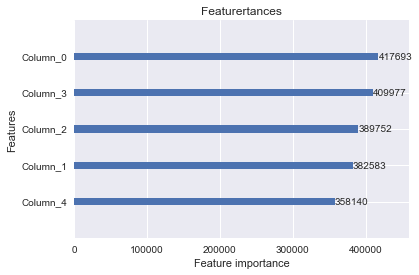

In [10]:
plt.figure(figsize=(12,6))
lgb.plot_importance(clf, max_num_features=6)
plt.title("Featurertances")
plt.show()

画出训练结果...


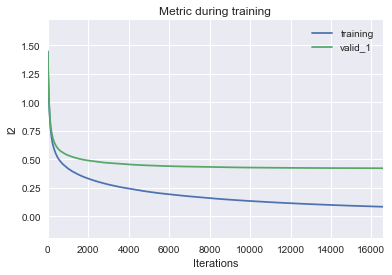

In [24]:
print('画出训练结果...')
ax = lgb.plot_metric(evals_result)#metric的值与之前的params里面的值对应
plt.show()